# Objective

Generate report about the pricing analysis and place the figures in the `reports/figures` folder.

# Code

## Load libs

In [30]:
import sys
sys.path.append('..')

import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from src.data.helpers import load_aws_dataset

## Input params

In [31]:
interim_dir = '../data/interim'
in_fname = 'step_1_aws_filtered_sample.csv.zip'
compression = 'zip'
report_dir = '../reports/figures/'

In [32]:
# Papermill parameters injection ... do not delete!

## Load data

In [33]:
file = f'{interim_dir}/{in_fname}'
data = load_aws_dataset(file)
print(data.shape)
data.head()

(1666418, 4)


/Users/walterwong/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Timestamp,AvailabilityZone,InstanceType,SpotPrice
0,2020-06-01 00:00:04,us-east-1f,r5d.large,0.0356
1,2020-06-01 00:00:04,us-east-1c,r5d.large,0.0356
2,2020-06-01 00:00:04,us-east-1d,r5d.large,0.0356
3,2020-06-01 00:00:04,us-east-1b,r5d.large,0.0356
4,2020-06-01 00:00:50,us-west-2c,r5.2xlarge,0.1560


## Filter data

Filter data only for `us-east-1a` at this moment.

In [34]:
%%time

df = data.query('AvailabilityZone == "us-east-1a"')\
         .drop('AvailabilityZone', axis=1)

print(df.shape)

# Pivot table to change a wide format for the data. Thus, we can remove
# instances that do not have any price update.
# Dropping MultiIndex column 'SpotPrice' as there is no use for it.
pvt = df.pivot_table(index=['Timestamp'], 
                     columns=['InstanceType'])\
        .droplevel(0, axis=1)

pvt.head()

(58756, 3)
CPU times: user 421 ms, sys: 198 ms, total: 619 ms
Wall time: 615 ms


InstanceType,a1.2xlarge,a1.4xlarge,a1.large,a1.medium,a1.metal,a1.xlarge,c1.medium,c1.xlarge,c3.2xlarge,c3.4xlarge,...,x1e.4xlarge,x1e.8xlarge,x1e.xlarge,z1d.12xlarge,z1d.2xlarge,z1d.3xlarge,z1d.6xlarge,z1d.large,z1d.metal,z1d.xlarge
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-01 00:05:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01 00:05:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01 00:06:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01 00:13:29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01 00:14:13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plotting

### Most volatile instances

Conclusion: these are the instances with more price changes, meaning that the user has more risk of losing them due to eviction based on price updates.

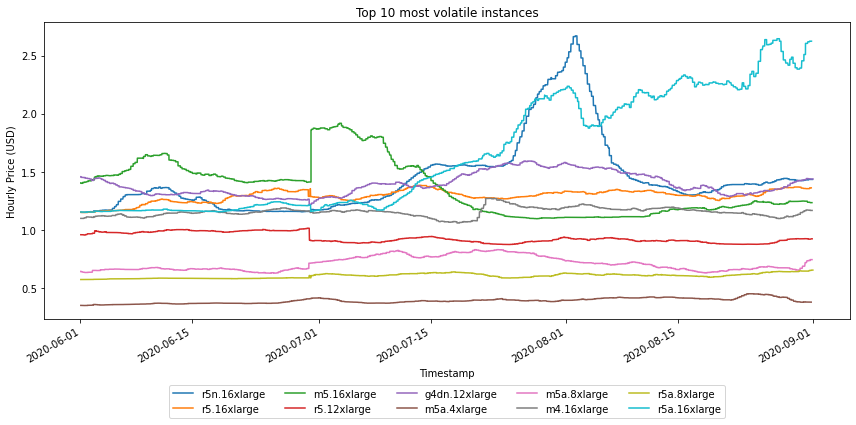

In [35]:
most_volatiles = pvt.count().sort_values(ascending=False).nlargest(10)
fig, ax = plt.subplots(figsize=(12, 6))

pvt.loc[:, most_volatiles.index.to_list()]\
    .dropna(how='all', axis=0)\
    .fillna(method='bfill').plot(ax=ax)

ax.set_title('Top 10 most volatile instances')
ax.set_ylabel('Hourly Price (USD)')
ax.legend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.35))

plt.tight_layout()
plt.savefig(f'{report_dir}/plot_step_4_most_volatile_instances.png', dpi=300)

### Least volatile instances

Conclusion: the least volatile instances simply don't have price change, which means they are a good pick to be used as spot instances

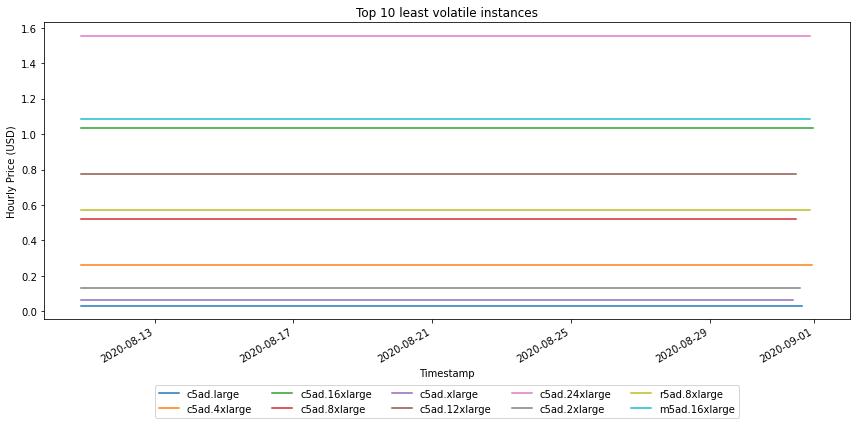

In [36]:
# Now getting the least volatile instances
least_volatiles = pvt.count().sort_values(ascending=False).nsmallest(10)

fig, ax = plt.subplots(figsize=(12, 6))

pvt.loc[:, least_volatiles.index.to_list()]\
    .dropna(how='all', axis=0)\
    .fillna(method='bfill').plot(ax=ax)

ax.set_title('Top 10 least volatile instances')
ax.set_ylabel('Hourly Price (USD)')
ax.legend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.35))

plt.tight_layout()
plt.savefig(f'{report_dir}/plot_step_4_least_volatile_instances.png', dpi=300)